## Modele de la probabilite de la survenance des sinistres

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

In [2]:
Actuar2=pd.read_csv("actuarNV1.csv",sep=";")

In [3]:
Actuar2.head()

,nocontrat,exposition,zone,puissance,agevehicule,ageconducteur,bonus,marque,carburant,densite,region,nbre,no,garantie,cout
0,217,0.74,A,5,4,31,64,3,D,21,8,1,17001,1RC,0.00
1,709,0.18,B,7,8,22,100,2,E,26,0,1,17419,1RC,0.00
2,714,0.48,C,9,0,32,61,12,E,41,13,1,15851,4BG,687.82
3,852,0.27,F,7,5,39,100,12,E,11,0,1,21407,2DO,96.64
4,1083,0.51,E,4,0,49,50,12,E,31,13,1,15589,2DO,70.88


In [4]:
#Suppression et Renomination des colonnes
Actuar2=Actuar2.drop(columns=['nocontrat'])
Actuar2=Actuar2.drop(columns=['no'])
Actuar2=Actuar2.drop(columns=['exposition'])
Actuar2=Actuar2.drop(columns=['region'])
Actuar2=Actuar2.drop(columns=['marque'])

Actuar2.rename(columns={
    'exposition':'exposition',
    'zone':'zone',
    'puissance':'puissance',
    'agevehicule':'age_vehicule',
    'ageconducteur':'age_conducteur',
    'bonus':'bonus',
    'marque':'marque',
    'carburant':'energie',
    'region':'region',
    'nbre':'frequence_sinistre',
    'garantie':'garantie',
    'cout':'cout'
},inplace=True)

In [5]:
#Affichage des colonnes renommees
Actuar2.columns

Index(['zone', 'puissance', 'age_vehicule', 'age_conducteur', 'bonus',
       'energie', 'densite', 'frequence_sinistre', 'garantie', 'cout'],
      dtype='object')

In [6]:
Actuar2.head()

,zone,puissance,age_vehicule,age_conducteur,bonus,energie,densite,frequence_sinistre,garantie,cout
0,A,5,4,31,64,D,21,1,1RC,0.00
1,B,7,8,22,100,E,26,1,1RC,0.00
2,C,9,0,32,61,E,41,1,4BG,687.82
3,F,7,5,39,100,E,11,1,2DO,96.64
4,E,4,0,49,50,E,31,1,2DO,70.88


In [7]:
# Vérifier les doublons dans l'ensemble du DataFrame
Actuar2.duplicated().sum()

9

In [8]:
Actuar2=Actuar2.drop_duplicates()

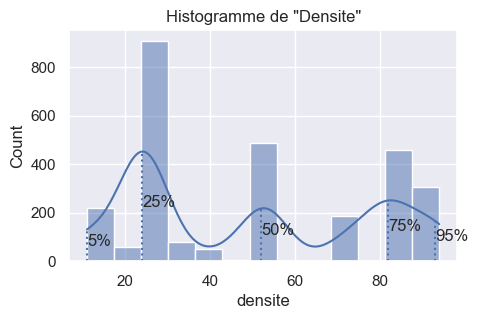

In [9]:
#Densite
sns.set(rc = {'figure.figsize':(5,3)})
ax = sns.histplot(x = Actuar2['densite'], kde=True)
quant_5 = Actuar2['densite'].quantile(0.05)
quant_25 = Actuar2['densite'].quantile(0.25)
quant_50 = Actuar2['densite'].quantile(0.5)
quant_75 = Actuar2['densite'].quantile(0.75)
quant_95 = Actuar2['densite'].quantile(0.95)
quant_dict = {'5%': quant_5, '25%': quant_25, '50%': quant_50, '75%': quant_75,'95%': quant_95}
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
for key, value in quant_dict.items():
    height = np.interp(value, xs, ys)
    ax.vlines(value, 0, height, ls=':')
    ax.text(value , height * 0.5, key, rotation=0)
plt.title('Histogramme de "Densite"')
plt.show()

In [10]:
variables_quantitatives=Actuar2.select_dtypes(include=['float64','int64']).columns

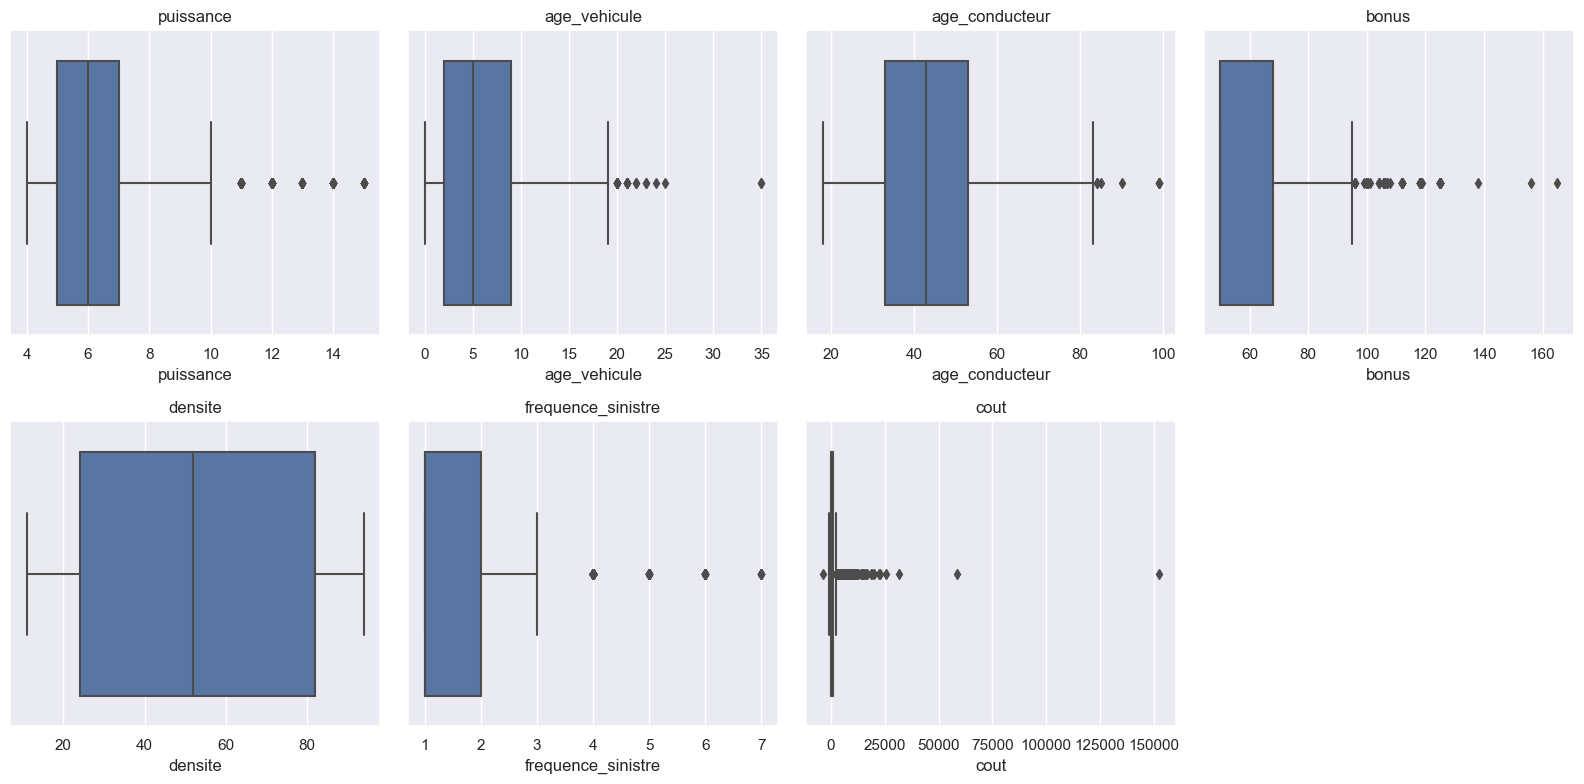

In [11]:
# Créer une disposition en grille pour les sous-graphiques avec 2 lignes et 4 colonnes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Parcourir chaque colonne et créer un diagramme en boîte pour les valeurs aberrantes
for i, colonne in enumerate(variables_quantitatives):
    # Calcul des positions dans la grille
    ligne = i // 4
    col = i % 4
    # Créer un diagramme en boîte pour chaque variable
    sns.boxplot(x=Actuar2[colonne], ax=axes[ligne, col])
    axes[ligne, col].set_title(colonne)  # Ajouter le titre de la variable

# Supprimer le dernier sous-graphe vide
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()

In [12]:
lower_limit=0.05
upper_limit=0.95

In [13]:
def winsorize_dataframe(Actuar2, lower_limit, upper_limit):
        """Winsorise les colonnes numériques d'un dataframe."""

   # Winsorise chaque colonne numérique

for col in variables_quantitatives:
        
        Actuar2[col] = winsorize(Actuar2[col], limits=[lower_limit, 1 - upper_limit])


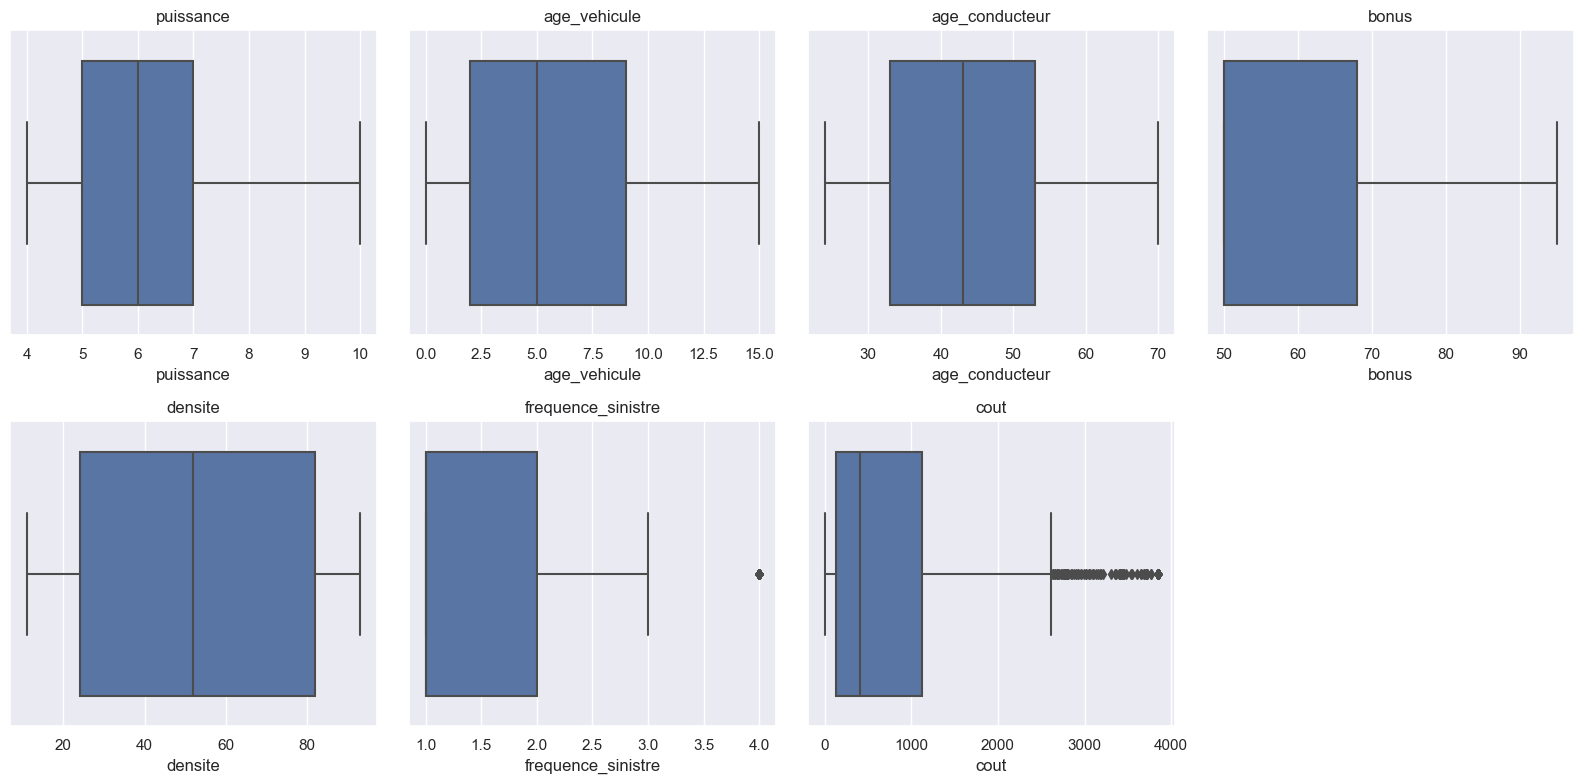

In [14]:
# Créer une disposition en grille pour les sous-graphiques avec 2 lignes et 4 colonnes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Parcourir chaque colonne et créer un diagramme en boîte pour les valeurs aberrantes
for i, colonne in enumerate(variables_quantitatives):
    # Calcul des positions dans la grille
    ligne = i // 4
    col = i % 4
    # Créer un diagramme en boîte pour chaque variable
    sns.boxplot(x=Actuar2[colonne], ax=axes[ligne, col])
    axes[ligne, col].set_title(colonne)  # Ajouter le titre de la variable

# Supprimer le dernier sous-graphe vide
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()


In [15]:
variables_qualitatives=Actuar2.select_dtypes(include=['object'])

In [16]:
#Dichotomisation de la variable dependante
Actuar2['frequence_sinistreB']=np.where(Actuar2['frequence_sinistre']>1,1,0)

In [17]:
Actuar2=Actuar2.drop(columns=['frequence_sinistre'])


In [18]:
Actuar2.sample(20)

,zone,puissance,age_vehicule,age_conducteur,bonus,energie,densite,garantie,cout,frequence_sinistreB
346,B,6,2,49,50,D,24,4BG,86.78,1
115,A,6,5,24,80,D,24,4BG,450.03,0
2074,A,4,11,43,50,E,26,4BG,998.38,0
957,C,5,10,30,72,D,53,1RC,3850.56,1
99,C,4,9,31,62,D,74,2DO,485.48,1
1621,E,6,12,46,50,D,82,1RC,89.00,0
2014,E,7,0,41,50,D,82,2DO,2593.62,1
304,D,6,2,53,95,E,11,1RC,148.68,1
593,D,6,6,42,51,D,82,2DO,0.00,1
1151,D,10,1,62,50,D,91,2DO,3850.56,0


<AxesSubplot: xlabel='zone', ylabel='frequence_sinistreB'>

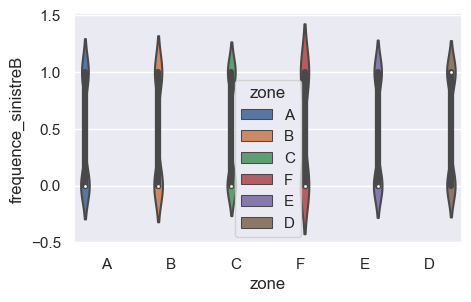

In [19]:
sns.violinplot(x = 'zone', y = 'frequence_sinistreB', data = Actuar2,hue='zone')

<AxesSubplot: xlabel='energie', ylabel='frequence_sinistreB'>

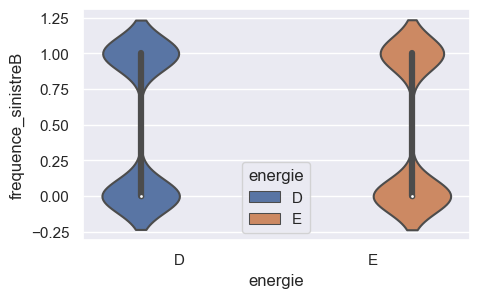

In [20]:
sns.violinplot(x = 'energie', y = 'frequence_sinistreB', data = Actuar2,hue='energie')

<AxesSubplot: xlabel='garantie', ylabel='frequence_sinistreB'>

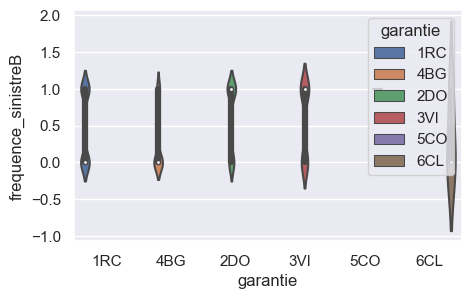

In [21]:
sns.violinplot(x = 'garantie', y = 'frequence_sinistreB', data = Actuar2,hue='garantie')

In [22]:
from scipy.stats import chi2_contingency


# Initialiser les listes pour stocker les résultats
var_names = []
chi2_stats = []
p_values = []
cramer_vs = []

# Parcourir toutes les variables qualitatives
for var in variables_qualitatives:
    # Calculer le tableau de contingence
    contingency_table = pd.crosstab(Actuar2['frequence_sinistreB'], Actuar2[var])
    # Calculer la statistique de test du Chi-deux et la p-valeur
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Calculer le coefficient V de Cramer
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rc = r - ((r - 1) ** 2) / (n - 1)
    kc = k - ((k - 1) ** 2) / (n - 1)
    cramer_v = np.sqrt(phi2corr / min(rc - 1, kc - 1))
    # Ajouter les résultats aux listes correspondantes
    var_names.append(var)
    chi2_stats.append(chi2)
    p_values.append(p)
    cramer_vs.append(cramer_v)

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Variable': var_names,
    'Chi2': chi2_stats,
    'P-valeur': p_values,
    'V de Cramer': cramer_vs
})

# Trier le DataFrame par ordre croissant de V de Cramer
results_df.sort_values(by='V de Cramer', inplace=True, ascending=False)

# Afficher le tableau des résultats
print(results_df)

   Variable        Chi2      P-valeur  V de Cramer
2  garantie  244.550289  8.114602e-51     0.294874
1   energie    5.360649  2.059611e-02     0.039783
0      zone    5.152385  3.975675e-01     0.007393


## Interprétation des résultats :
**Variable garantie** :

*Chi2* : 244.55
*P-valeur* : 8.11e-51
*V de Cramer* : 0.2949

La statistique Chi-deux est très élevée (244.55) et la p-valeur est extrêmement faible (8.11e-51), bien en dessous du seuil typique de 0.05. Cela indique une association statistiquement significative entre garantie et frequence_sinistre. Le coefficient V de Cramer (0.2949) suggère une association modérée entre ces deux variables.

**Variable energie** :

*Chi2* : 5.36
*P-valeur* : 0.0206
*V de Cramer* : 0.0398

La statistique Chi-deux est de 5.36 et la p-valeur est faible (0.0206), en dessous de 0.05. Cela indique une association statistiquement significative entre energie et frequence_sinistre. Cependant, le coefficient V de Cramer (0.0398) suggère une association très faible entre ces deux variables.

**Variable zone** :

*Chi2* : 5.15
*P-valeur* : 0.3976
*V de Cramer* : 0.0074

La statistique Chi-deux est de 5.15, mais la p-valeur est de 0.3976, bien au-dessus du seuil de 0.05. Cela indique qu'il n'y a pas d'association statistiquement significative entre zone et frequence_sinistre. Le coefficient V de Cramer est de 0.0074, confirmant qu'il n'y a aucune association entre zone et frequence_sinistre.

## Conclusion :
garantie et frequence_sinistre : Il existe une association statistiquement significative avec une force d'association modérée.
energie et frequence_sinistre : Il existe une association statistiquement significative avec une force d'association très faible.
zone et frequence_sinistre : Il n'y a pas d'association statistiquement significative.
Ces résultats indiquent que la variable garantie a une influence modérée sur frequence_sinistre, tandis que la variable energie a une influence très faible. La variable zone, quant à elle, n'a pas d'influence significative sur frequence_sinistre.

In [23]:
from sklearn.preprocessing import LabelEncoder


In [24]:
encoded=LabelEncoder().fit_transform(Actuar2['zone'])
encoded=LabelEncoder().fit_transform(Actuar2['energie'])
encoded=LabelEncoder().fit_transform(Actuar2['garantie'])

Actuar2['zone']=encoded
Actuar2['energie']=encoded
Actuar2['garantie']=encoded

Actuar2.head()

,zone,puissance,age_vehicule,age_conducteur,bonus,energie,densite,garantie,cout,frequence_sinistreB
0,0,5,4,31,64,0,21,0,0.00,0
1,0,7,8,24,95,0,26,0,0.00,0
2,3,9,0,32,61,3,41,3,687.82,0
3,1,7,5,39,95,1,11,1,96.64,0
4,1,4,0,49,50,1,31,1,70.88,0


In [23]:
import statsmodels.api as sm

In [24]:
# Séparation des caractéristiques et de l'étiquette
X2 = Actuar2[['zone','puissance','age_vehicule','age_conducteur','bonus','energie','densite','garantie','cout']]
Y2 = Actuar2['frequence_sinistreB']



In [25]:
# Convertir les variables catégorielles en variables indicatrices (dummies)
X2 = pd.get_dummies(X2, columns=['zone', 'energie', 'garantie'], drop_first=True)

In [26]:
X2

,puissance,age_vehicule,age_conducteur,bonus,densite,cout,zone_B,zone_C,zone_D,zone_E,zone_F,energie_E,garantie_2DO,garantie_3VI,garantie_4BG,garantie_5CO,garantie_6CL
0,5,4,31,64,21,0.00,0,0,0,0,0,0,0,0,0,0,0
1,7,8,24,95,26,0.00,1,0,0,0,0,1,0,0,0,0,0
2,9,0,32,61,41,687.82,0,1,0,0,0,1,0,0,1,0,0
3,7,5,39,95,11,96.64,0,0,0,0,1,1,1,0,0,0,0
4,4,0,49,50,31,70.88,0,0,0,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,7,8,31,54,52,156.23,1,0,0,0,0,1,0,0,1,0,0
2761,5,4,32,57,24,74.15,0,1,0,0,0,0,0,0,0,0,0
2762,5,15,44,50,24,325.57,0,0,0,0,0,1,0,0,1,0,0
2763,5,7,48,50,24,387.04,0,1,0,0,0,0,0,0,1,0,0


In [27]:
# Diviser les données en ensembles d'apprentissage et de test
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

In [28]:
# Créer le modèle de régression logistique
logit_model = sm.Logit(Y2_train, X2_train)

In [29]:
# Ajuster le modèle aux données d'apprentissage
result = logit_model.fit()

         Current function value: 0.640166
         Iterations: 35


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
# Afficher le résumé des résultats de la régression
print(result.summary())

                            Logit Regression Results                           
Dep. Variable:     frequence_sinistreB   No. Observations:                 2204
Model:                           Logit   Df Residuals:                     2187
Method:                            MLE   Df Model:                           16
Date:                 Thu, 25 Jul 2024   Pseudo R-squ.:                 0.07381
Time:                         23:50:53   Log-Likelihood:                -1410.9
converged:                       False   LL-Null:                       -1523.4
Covariance Type:             nonrobust   LLR p-value:                 7.028e-39
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
puissance          0.0022      0.025      0.090      0.929      -0.046       0.051
age_vehicule      -0.0422      0.011     -3.971      0.000      -0.063      -0.021
age_conducteur     0.0015   

Le tableau des résultats de la régression logistique donne plusieurs informations importantes. Voici une interprétation détaillée des différents éléments :

### Informations Générales

- *Dep. Variable* : La variable dépendante est frequence_sinistreB.
- *No. Observations* : Il y a 2204 observations.
- *Model* : Le modèle utilisé est la régression logistique (Logit).
- *Method* : La méthode d'estimation utilisée est la méthode du maximum de vraisemblance (MLE).
- *Pseudo R-squ.* : Le pseudo R-carré est de 0.07381, ce qui indique une mesure de la proportion de la variation expliquée par le modèle.
- *Log-Likelihood* : La log-vraisemblance est de -1410.9.
- *LL-Null* : La log-vraisemblance du modèle nul est de -1523.4.
- *LLR p-value* : La valeur p du test du rapport de vraisemblance est 7.028e-39, ce qui indique que le modèle est statistiquement significatif.
- *Converged* : False indique que le modèle n'a pas convergé correctement, ce qui pourrait être un problème sérieux.

### Interprétation des Coefficients

Pour chaque variable indépendante, les informations suivantes sont fournies :

- *coef* : Le coefficient estimé pour chaque variable.
- *std err* : L'erreur standard du coefficient estimé.
- *z* : La statistique z, qui est le ratio du coefficient à son erreur standard.
- *P>|z|* : La valeur p associée à la statistique z, indiquant si le coefficient est statistiquement significatif.
- *[0.025, 0.975]* : Les intervalles de confiance à 95% pour le coefficient.

Voici quelques points clés :

- *age_vehicule* : Le coefficient est -0.0422, avec une valeur p de 0.000, indiquant que cette variable est significativement associée à la variable dépendante. Un âge plus élevé du véhicule diminue la fréquence des sinistres.
- *energie_E* : Le coefficient est -0.2204, avec une valeur p de 0.018, indiquant que cette variable est également significative. Cela suggère que les véhicules à énergie alternative ont une fréquence de sinistres différente par rapport à la catégorie de référence.
- *garantie_2DO* : Le coefficient est 0.4227, avec une valeur p de 0.000, montrant une association positive significative avec la fréquence des sinistres.
- *garantie_4BG* : Le coefficient est -1.0561, avec une valeur p de 0.000, indiquant une association négative significative.
- *garantie_5CO* : Le coefficient est extrêmement élevé (12.7113) mais avec une énorme erreur standard et une valeur p de 0.959, ce qui signifie qu'il n'est pas statistiquement significatif et pourrait indiquer des problèmes de colinéarité ou des valeurs aberrantes.
- *autres variables* : Plusieurs autres variables ne sont pas significatives (par exemple, puissance, age_conducteur, bonus, densite), ce qui signifie que leurs coefficients ne sont pas statistiquement différents de zéro.

### Conclusion

Bien que certains coefficients soient significatifs, le fait que le modèle n'ait pas convergé correctement est préoccupant. Cela pourrait indiquer plusieurs problèmes potentiels, tels que la multicolinéarité, des données aberrantes, ou simplement que le modèle nécessite plus d'itérations pour converger. Vous pourriez essayer de résoudre ces problèmes en examinant les données de plus près, en supprimant les variables non significatives, ou en ajustant les paramètres de l'algorithme d'optimisation.

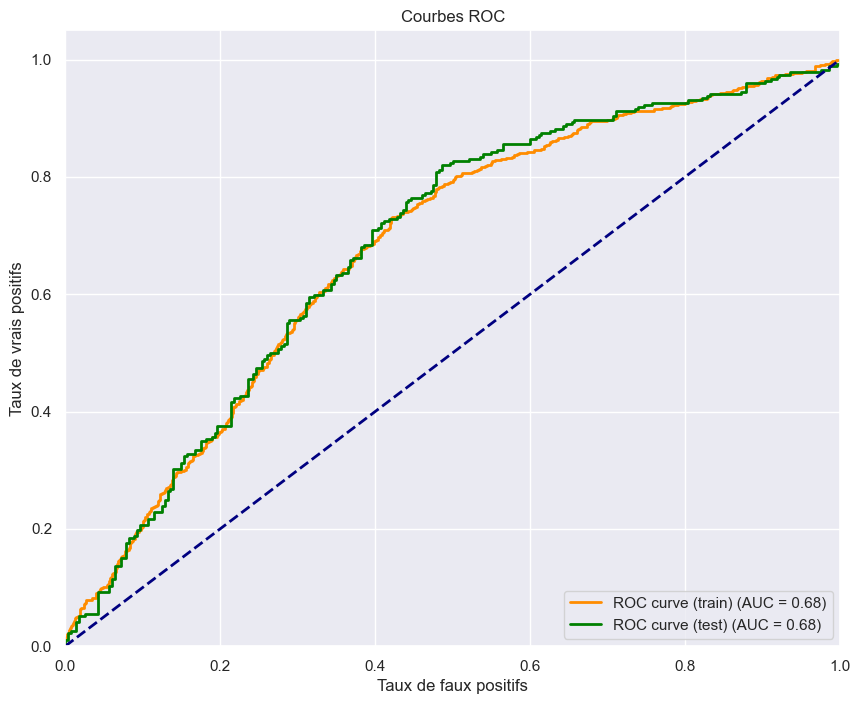

In [31]:
from sklearn.metrics import roc_curve, auc
# Obtenir les prédictions du modèle sur l'ensemble d'entraînement et de test
Y2_train_pred = result.predict(X2_train)
Y2_test_pred = result.predict(X2_test)

# Calculer les courbes ROC et les aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(Y2_train, Y2_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(Y2_test, Y2_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()


In [32]:
from sklearn.metrics import classification_report

# Prédire les classes sur la base de test
Y2_pred = result.predict(X2_test) > 0.5

# Générer le rapport de classification
report = classification_report(Y2_test, Y2_pred)

# Afficher le rapport de classification
print(report)

              precision    recall  f1-score   support

           0       0.66      0.61      0.64       280
           1       0.63      0.68      0.65       272

    accuracy                           0.65       552
   macro avg       0.65      0.65      0.65       552
weighted avg       0.65      0.65      0.65       552




| Classe | Précision | Rappel | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0      | 0.66      | 0.61   | 0.64     | 280     |
| 1      | 0.63      | 0.68   | 0.65     | 272     |

| Mesure       | Valeur |
|---------------|--------|
| Exactitude    | 0.65   |
| Macro Moyenne | 0.65   |
| Moyenne Pondérée | 0.65 |


Ce tableau présente les métriques de performance pour un modèle de classification binaire, probablement une régression logistique, évalué sur un ensemble de test. Voici comment interpréter les différentes métriques :

### Interprétation des métriques

#### Classe 0

- *Precision (Précision)* : \(0.66\)
  - La précision mesure la proportion de vrais positifs parmi les exemples prédits positifs. Ici, 66% des exemples prédits comme appartenant à la classe 0 étaient effectivement de la classe 0.
- *Recall (Rappel)* : \(0.61\)
  - Le rappel mesure la proportion de vrais positifs parmi tous les exemples de la classe 0. Ici, 61% des exemples de la classe 0 ont été correctement identifiés.
- *F1-score* : \(0.64\)
  - Le F1-score est la moyenne harmonique de la précision et du rappel, donnant une mesure équilibrée de la performance du modèle. Ici, il est de 0.64.
- *Support* : \(280\)
  - Le support représente le nombre total d'exemples de la classe 0 dans l'ensemble de test.

#### Classe 1

- *Precision (Précision)* : \(0.63\)
  - La précision pour la classe 1 est de 63%.
- *Recall (Rappel)* : \(0.68\)
  - Le rappel pour la classe 1 est de 68%.
- *F1-score* : \(0.65\)
  - Le F1-score pour la classe 1 est de 0.65.
- *Support* : \(272\)
  - Le support pour la classe 1 est de 272.

#### Total (Global)

- *Accuracy (Exactitude)* : \(0.65\)
  - L'exactitude est la proportion d'exemples correctement classifiés sur l'ensemble total. Ici, 65% des exemples sont correctement classifiés.
- *Macro avg (Moyenne macro)* : \(0.65\)
  - La moyenne macro est la moyenne non pondérée des métriques (précision, rappel, F1-score) pour chaque classe. Elle traite toutes les classes de manière égale. Ici, elle est de 0.65 pour toutes les métriques.
- *Weighted avg (Moyenne pondérée)* : \(0.65\)
  - La moyenne pondérée prend en compte le support de chaque classe lors du calcul des métriques globales. Elle est également de 0.65 pour toutes les métriques.

### Conclusion

Les performances du modèle sont équilibrées entre les deux classes avec une précision, un rappel et un F1-score global de 0.65. Cela signifie que le modèle est modérément bon pour prédire les deux classes, mais il y a probablement encore de la place pour l'amélioration. Vous pourriez envisager d'ajuster les hyperparamètres du modèle, de traiter les déséquilibres de classe, ou d'explorer d'autres algorithmes de classification pour améliorer les performances.

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y2_test, Y2_pred)
print(confusion_matrix)

[[172 108]
 [ 87 185]]


Ce tableau est une matrice de confusion pour un modèle de classification binaire. Elle présente le nombre de prédictions correctes et incorrectes pour chaque classe. Voici comment interpréter ce tableau :

### Interprétation de la Matrice de Confusion

|             | Prédiction: Classe 0 | Prédiction: Classe 1 |
|-------------|----------------------|----------------------|
| *Réel: Classe 0* | 172                  | 108                  |
| *Réel: Classe 1* | 87                   | 185                  |

- *172 (Vrais Négatifs)* :
  - Nombre d'exemples de la classe 0 correctement prédits comme classe 0.

- *108 (Faux Positifs)* :
  - Nombre d'exemples de la classe 0 incorrectement prédits comme classe 1.

- *87 (Faux Négatifs)* :
  - Nombre d'exemples de la classe 1 incorrectement prédits comme classe 0.

- *185 (Vrais Positifs)* :
  - Nombre d'exemples de la classe 1 correctement prédits comme classe 1.

### Calcul des Métriques de Performance

À partir de cette matrice de confusion, nous pouvons calculer les principales métriques de performance.

#### Précision (Precision)
- *Classe 0* : \( \frac{172}{172 + 87} = \frac{172}{259} \approx 0.66 \)
- *Classe 1* : \( \frac{185}{185 + 108} = \frac{185}{293} \approx 0.63 \)

#### Rappel (Recall)
- *Classe 0* : \( \frac{172}{172 + 108} = \frac{172}{280} \approx 0.61 \)
- *Classe 1* : \( \frac{185}{185 + 87} = \frac{185}{272} \approx 0.68 \)

#### F1-score
- *Classe 0* : \( \frac{2 \times 0.66 \times 0.61}{0.66 + 0.61} \approx 0.64 \)
- *Classe 1* : \( \frac{2 \times 0.63 \times 0.68}{0.63 + 0.68} \approx 0.65 \)

#### Exactitude (Accuracy)
- \( \frac{172 + 185}{172 + 108 + 87 + 185} = \frac{357}{552} \approx 0.65 \)

### Conclusion

Ces calculs confirment les valeurs précédentes fournies pour la précision, le rappel et le F1-score. Le modèle a une performance équilibrée avec une précision globale, un rappel et un F1-score de 0.65, indiquant une performance modérée pour la prédiction des deux classes. 

Pour améliorer ces résultats, vous pourriez :
- Explorer d'autres algorithmes de classification.
- Ajuster les hyperparamètres de votre modèle actuel.
- Gérer tout déséquilibre de classes potentiellement présent dans vos données.
- Envisager d'ajouter ou de transformer des caractéristiques (features) pour améliorer la capacité du modèle à distinguer entre les classes.

In [34]:
from sklearn.metrics import classification_report

# Prédire les classes sur la base de test
Y2_pred = result.predict(X2_train) > 0.5

# Générer le rapport de classification
report = classification_report(Y2_train, Y2_pred)

# Afficher le rapport de classification
print(report)

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1171
           1       0.61      0.67      0.64      1033

    accuracy                           0.64      2204
   macro avg       0.64      0.65      0.64      2204
weighted avg       0.65      0.64      0.64      2204



| Classe | Précision | Rappel | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0      | 0.68      | 0.62   | 0.65     | 1171    |
| 1      | 0.61      | 0.67   | 0.64     | 1033    |

| Mesure       | Valeur |
|---------------|--------|
| Exactitude    | 0.64   |
| Macro Moyenne | 0.64   |
| Moyenne Pondérée | 0.65 |


Ce tableau présente les métriques de performance pour un modèle de classification binaire, basé sur un ensemble de test de 2204 observations. Voici une interprétation détaillée des différentes métriques :

### Interprétation des Métriques

#### Classe 0

- *Precision (Précision)* : \(0.68\)
  - La précision mesure la proportion de vrais positifs parmi les exemples prédits positifs. Ici, 68% des exemples prédits comme appartenant à la classe 0 étaient effectivement de la classe 0.
- *Recall (Rappel)* : \(0.62\)
  - Le rappel mesure la proportion de vrais positifs parmi tous les exemples de la classe 0. Ici, 62% des exemples de la classe 0 ont été correctement identifiés.
- *F1-score* : \(0.65\)
  - Le F1-score est la moyenne harmonique de la précision et du rappel, donnant une mesure équilibrée de la performance du modèle. Ici, il est de 0.65.
- *Support* : \(1171\)
  - Le support représente le nombre total d'exemples de la classe 0 dans l'ensemble de test.

#### Classe 1

- *Precision (Précision)* : \(0.61\)
  - La précision pour la classe 1 est de 61%.
- *Recall (Rappel)* : \(0.67\)
  - Le rappel pour la classe 1 est de 67%.
- *F1-score* : \(0.64\)
  - Le F1-score pour la classe 1 est de 0.64.
- *Support* : \(1033\)
  - Le support pour la classe 1 est de 1033.

#### Total (Global)

- *Accuracy (Exactitude)* : \(0.64\)
  - L'exactitude est la proportion d'exemples correctement classifiés sur l'ensemble total. Ici, 64% des exemples sont correctement classifiés.
- *Macro avg (Moyenne macro)* : \(0.64\)
  - La moyenne macro est la moyenne non pondérée des métriques (précision, rappel, F1-score) pour chaque classe. Elle traite toutes les classes de manière égale. Ici, elle est de 0.64 pour la précision, le rappel et le F1-score.
- *Weighted avg (Moyenne pondérée)* : \(0.65\)
  - La moyenne pondérée prend en compte le support de chaque classe lors du calcul des métriques globales. Elle est de 0.65 pour la précision, et de 0.64 pour le rappel et le F1-score.

### Conclusion

Les performances du modèle sont équilibrées entre les deux classes avec des précisions, des rappels et des F1-scores globalement similaires autour de 0.64-0.65. L'exactitude globale est de 0.64, indiquant que le modèle est modérément bon pour prédire les deux classes, mais il y a probablement encore de la place pour l'amélioration.

### Actions potentielles pour l'amélioration

1. *Ajustement des hyperparamètres* :
   - Ajustez les hyperparamètres du modèle actuel pour voir si vous pouvez améliorer les performances.

2. *Ensemble de modèles (Ensembling)* :
   - Envisagez d'utiliser des techniques d'ensemble comme le bagging, le boosting ou les forêts aléatoires pour améliorer les performances.

3. *Feature Engineering* :
   - Ajoutez, modifiez ou supprimez des caractéristiques (features) pour voir si cela améliore les performances du modèle.

4. *Gestion des déséquilibres de classe* :
   - Si vos classes sont déséquilibrées, essayez des techniques de sous-échantillonnage, de sur-échantillonnage ou d'utilisation de pénalités pour la classe minoritaire.

5. *Exploration d'autres algorithmes de classification* :
   - Essayez d'autres algorithmes de classification comme les SVM, les réseaux neuronaux, ou les modèles de gradient boosting pour voir si vous pouvez obtenir de meilleures performances.

En utilisant ces stratégies, vous pouvez potentiellement améliorer les métriques de performance de votre modèle.

Voici l'interprétation des métriques de performance pour les ensembles de données d'entraînement et de test :

### 1. *R² (Coefficient de Détermination)*

- *Train* : 0.012993
- *Test* : 0.019092

*Interprétation* :
- Le R² mesure la proportion de la variance des données expliquée par le modèle. Une valeur de 0 indique que le modèle n'explique aucune variance, tandis qu'une valeur de 1 indique que le modèle explique toute la variance.
- Les valeurs proches de 0 pour les ensembles d'entraînement et de test suggèrent que le modèle ne capture pas bien la variance des données. Le modèle est donc très peu performant.

### 2. *MSE (Mean Squared Error - Erreur Quadratique Moyenne)*

- *Train* : 939276.552089
- *Test* : 830037.142980

*Interprétation* :
- Le MSE mesure la moyenne des carrés des erreurs. Plus le MSE est bas, mieux le modèle prédit les valeurs réelles.
- Le MSE est légèrement plus bas pour le test que pour l'entraînement, ce qui peut indiquer une légère amélioration en généralisation, mais les valeurs sont toutes deux très élevées, ce qui suggère que le modèle a des erreurs importantes dans ses prédictions.

### 3. *RMSE (Root Mean Squared Error - Erreur Quadratique Moyenne Racine)*

- *Train* : 969.162810
- *Test* : 911.063743

*Interprétation* :
- Le RMSE est la racine carrée du MSE et fournit une mesure de l'erreur en unités des valeurs de la variable cible. Il est plus facile à interpréter que le MSE car il est dans la même unité que les données.
- Le RMSE est légèrement plus bas pour le test que pour l'entraînement, indiquant une légère amélioration sur les données de test. Cependant, les deux valeurs de RMSE sont élevées, ce qui signifie que les erreurs de prédiction du modèle sont importantes.

### Conclusion

- *Performance Générale* : Le modèle a une faible capacité à expliquer la variance des données (R² proche de 0), et les erreurs (MSE et RMSE) sont élevées, indiquant que le modèle a du mal à prédire les valeurs de manière précise, tant sur les données d'entraînement que sur les données de test.
- *Overfitting / Underfitting* : Les valeurs de MSE et RMSE sont relativement proches entre l'entraînement et le test, ce qui suggère que le modèle ne surajuste pas particulièrement les données d'entraînement, mais qu'il pourrait ne pas être bien ajusté du tout (underfitting).

Il pourrait être nécessaire d'explorer des modèles différents, de faire des ajustements de caractéristiques, ou d'optimiser les hyperparamètres pour améliorer la performance du modèle.